# Pandas 3:  Shaping data  

The second in a series of notebooks that describe Pandas' powerful data management tools.  This one covers indexing methods, pivoting, and stacking.  

Outline:  

* [Examples](#wants)
* [Indexing](#index).  Setting and resetting the index.  Multi-indexes. 
* [Switching rows and columns](#pivot).  Transpose.  Pivot and melt.  
* [Stack and unstack](#stack).  Managing column structure and labels.  Melt.  

More data management topics coming.  

**Note: requires internet access to run.**  

<!-- 
internal links http://sebastianraschka.com/Articles/2014_ipython_internal_links.html
-->

This IPython notebook was created by Dave Backus, Chase Coleman, and Spencer Lyon for the NYU Stern course [Data Bootcamp](http://databootcamp.nyuecon.com/).  

<a id=prelims></a>

## Preliminaries 

In [1]:
import sys                             # system module 
import pandas as pd                    # data package
import matplotlib.pyplot as plt        # graphics module  
import datetime as dt                  # date and time module
import numpy as np                     # foundation for Pandas 

%matplotlib inline                     

# check versions (overkill, but why not?)
print('Python version:', sys.version)
print('Pandas version: ', pd.__version__)
print('Today: ', dt.date.today())

Python version: 3.5.1 |Anaconda 4.0.0 (64-bit)| (default, Feb 16 2016, 09:49:46) [MSC v.1900 64 bit (AMD64)]
Pandas version:  0.18.0
Today:  2016-04-06


<a id=wants></a>

## Examples 

We load some of the examples from the previous notebook. The two examples share a problem:  variables run across rows, rather than down columns.  Our **want** in each case is to flip rows and columns somehow so that we can plot the data against time.  The question is how.

### Example:  OECD healthcare statistics 

The OECD collects [healthcare data](http://www.oecd.org/els/health-systems/health-data.htm) on lots of (mostly rich) countries, which is helpful in producing comparisons.  Here we use a [spreadsheet](http://www.oecd.org/health/health-systems/OECD-Health-Statistics-2015-Frequently-Requested-Data.xls) linked in one of their documents. 

In [3]:
url1 = 'http://www.oecd.org/health/health-systems/'
url2 = 'OECD-Health-Statistics-2015-Frequently-Requested-Data.xls'
docs = pd.read_excel(url1+url2, 
                     skiprows=3, 
                     usecols=[0, 51, 52, 53, 54, 55, 57],
                     sheetname='Physicians', 
                     na_values=['..'],   # added 
                     skip_footer=21) 
print('Dimensions:', docs.shape)
print('\nVariable dtypes:\n', docs.dtypes.tail(8), sep='')

# change name of country variable 
names = docs.columns
docs = docs.rename(columns={names[0]: 'Country'})

# fix country variable 
# now assign it back to the variable 
docs['Country'] = docs['Country'].str.rsplit(n=1).str[0]

docs.head()

Dimensions: (34, 7)

Variable dtypes:
Unnamed: 0                 object
2010                      float64
2011                      float64
2012                      float64
2013                      float64
2014                      float64
2013 (or nearest year)    float64
dtype: object


,Country,2010,2011,2012,2013,2014,2013 (or nearest year)
0,Australia,NaN,3.31,3.31,3.39,NaN,3.39
1,Austria,4.80,4.84,4.90,4.99,NaN,4.99
2,Belgium,2.92,2.91,2.93,2.95,NaN,2.95
3,Canada,2.37,2.44,2.50,2.55,NaN,2.55
4,Chile,1.43,1.58,1.74,1.88,2.02,1.88


### Example:  World Economic Outlook 

We look at a subset of the IMF's [World Economic Outlook database](https://www.imf.org/external/ns/cs.aspx?id=28) that contains two variables and three countries.  

In [4]:
url1 = 'http://www.imf.org/external/pubs/ft/weo/2015/02/weodata/'
url2 = 'WEOOct2015all.xls'
url = url1 + url2 
weo = pd.read_csv(url, sep='\t', 
                  usecols=[1,2,3,4,6,40,41,42,43,44], 
                  thousands=',', 
                  na_values=['n/a', '--']) 

print('Variable dtypes:\n', weo.dtypes, sep='')

# choose two variables and three countries 
variables = ['GGXWDG_NGDP', 'GGXCNL_NGDP']
countries = ['ARG', 'DEU', 'GRC']
weo_sub = weo[weo['WEO Subject Code'].isin(variables) & weo['ISO'].isin(countries)]

# change column labels to something more intuitive 
weo_sub = weo_sub.rename(columns=
                         {'WEO Subject Code': 'Variable', 
                          'Subject Descriptor': 'Description'})
#['GGXWDG_NGDP', 'GGXCNL_NGDP']
weo_sub

Variable dtypes:
ISO                    object
WEO Subject Code       object
Country                object
Subject Descriptor     object
Units                  object
2011                  float64
2012                  float64
2013                  float64
2014                  float64
2015                  float64
dtype: object


,ISO,Variable,Country,Description,Units,2011,2012,2013,2014,2015
252,ARG,GGXCNL_NGDP,Argentina,General government net lending/borrowing,Percent of GDP,-1.949,-2.359,-1.997,-2.689,-4.852
260,ARG,GGXWDG_NGDP,Argentina,General government gross debt,Percent of GDP,35.763,37.328,40.217,45.282,52.137
2716,DEU,GGXCNL_NGDP,Germany,General government net lending/borrowing,Percent of GDP,-0.861,0.091,0.133,0.306,0.511
2724,DEU,GGXWDG_NGDP,Germany,General government gross debt,Percent of GDP,77.928,79.311,76.978,74.621,70.746
2804,GRC,GGXCNL_NGDP,Greece,General government net lending/borrowing,Percent of GDP,-10.215,-6.406,-2.944,-3.914,-4.171
2812,GRC,GGXWDG_NGDP,Greece,General government gross debt,Percent of GDP,170.960,156.494,174.951,177.054,196.950


<a id='strings'></a>

<a id='missing'></a>

<a id='index'></a>

## Setting and resetting the index

We start by setting (and resetting) the index.  That may sound like a step backwards -- didn't we already do this? -- but it reminds us of some things that will be handy later.  

Take the dataframe `weo_wub`.  What would we like in the index?  Evenutally we'd like the dates `[2011, 2012, 2013, 2014, 2015]` in the index, but right now the row labels are more naturally the variable or country.  Here are some varriants.  

### Setting the index

In [5]:
weo_sub.set_index(['Country'])

,ISO,Variable,Description,Units,2011,2012,2013,2014,2015
Country,,,,,,,,,
Argentina,ARG,GGXCNL_NGDP,General government net lending/borrowing,Percent of GDP,-1.949,-2.359,-1.997,-2.689,-4.852
Argentina,ARG,GGXWDG_NGDP,General government gross debt,Percent of GDP,35.763,37.328,40.217,45.282,52.137
Germany,DEU,GGXCNL_NGDP,General government net lending/borrowing,Percent of GDP,-0.861,0.091,0.133,0.306,0.511
Germany,DEU,GGXWDG_NGDP,General government gross debt,Percent of GDP,77.928,79.311,76.978,74.621,70.746
Greece,GRC,GGXCNL_NGDP,General government net lending/borrowing,Percent of GDP,-10.215,-6.406,-2.944,-3.914,-4.171
Greece,GRC,GGXWDG_NGDP,General government gross debt,Percent of GDP,170.960,156.494,174.951,177.054,196.950


In [6]:
weo_sub.set_index(['Variable'])

,ISO,Country,Description,Units,2011,2012,2013,2014,2015
Variable,,,,,,,,,
GGXCNL_NGDP,ARG,Argentina,General government net lending/borrowing,Percent of GDP,-1.949,-2.359,-1.997,-2.689,-4.852
GGXWDG_NGDP,ARG,Argentina,General government gross debt,Percent of GDP,35.763,37.328,40.217,45.282,52.137
GGXCNL_NGDP,DEU,Germany,General government net lending/borrowing,Percent of GDP,-0.861,0.091,0.133,0.306,0.511
GGXWDG_NGDP,DEU,Germany,General government gross debt,Percent of GDP,77.928,79.311,76.978,74.621,70.746
GGXCNL_NGDP,GRC,Greece,General government net lending/borrowing,Percent of GDP,-10.215,-6.406,-2.944,-3.914,-4.171
GGXWDG_NGDP,GRC,Greece,General government gross debt,Percent of GDP,170.960,156.494,174.951,177.054,196.950


In [7]:
# we can do this with two or more if we like 
wi = weo_sub.set_index(['Variable', 'Country', 'ISO', 'Description', 'Units'])
wi

,,,,,2011,2012,2013,2014,2015
Variable,Country,ISO,Description,Units,,,,,
GGXCNL_NGDP,Argentina,ARG,General government net lending/borrowing,Percent of GDP,-1.949,-2.359,-1.997,-2.689,-4.852
GGXWDG_NGDP,Argentina,ARG,General government gross debt,Percent of GDP,35.763,37.328,40.217,45.282,52.137
GGXCNL_NGDP,Germany,DEU,General government net lending/borrowing,Percent of GDP,-0.861,0.091,0.133,0.306,0.511
GGXWDG_NGDP,Germany,DEU,General government gross debt,Percent of GDP,77.928,79.311,76.978,74.621,70.746
GGXCNL_NGDP,Greece,GRC,General government net lending/borrowing,Percent of GDP,-10.215,-6.406,-2.944,-3.914,-4.171
GGXWDG_NGDP,Greece,GRC,General government gross debt,Percent of GDP,170.960,156.494,174.951,177.054,196.950


**Comment.** This is called a multi-index, meaning that the index has more than one component.  We refer to the components as levels, which are numbered from the left starting at zero.  

This isn't uncommon.  A typical spreadsheet has two dimensions:  the variable and the observation.  The WEO data is naturally three dimensional:  the variable, the year, and the country.  The problem we're having is fitting this nicely into two dimensions.  A multi-index allows us to manage more than two.  

## Resetting the index

This is the reverse operation to setting the index.  For example:  

In [49]:
wi.reset_index()

,Variable,Country,ISO,Description,Units,2011,2012,2013,2014,2015
0,GGXCNL_NGDP,Argentina,ARG,General government net lending/borrowing,Percent of GDP,-1.949,-2.359,-1.997,-2.689,-4.852
1,GGXWDG_NGDP,Argentina,ARG,General government gross debt,Percent of GDP,35.763,37.328,40.217,45.282,52.137
2,GGXCNL_NGDP,Germany,DEU,General government net lending/borrowing,Percent of GDP,-0.861,0.091,0.133,0.306,0.511
3,GGXWDG_NGDP,Germany,DEU,General government gross debt,Percent of GDP,77.928,79.311,76.978,74.621,70.746
4,GGXCNL_NGDP,Greece,GRC,General government net lending/borrowing,Percent of GDP,-10.215,-6.406,-2.944,-3.914,-4.171
5,GGXWDG_NGDP,Greece,GRC,General government gross debt,Percent of GDP,170.960,156.494,174.951,177.054,196.950


In [50]:
# or we can reset the index level by level
wi.reset_index(level=1)

,,,,Country,2011,2012,2013,2014,2015
Variable,ISO,Description,Units,,,,,,
GGXCNL_NGDP,ARG,General government net lending/borrowing,Percent of GDP,Argentina,-1.949,-2.359,-1.997,-2.689,-4.852
GGXWDG_NGDP,ARG,General government gross debt,Percent of GDP,Argentina,35.763,37.328,40.217,45.282,52.137
GGXCNL_NGDP,DEU,General government net lending/borrowing,Percent of GDP,Germany,-0.861,0.091,0.133,0.306,0.511
GGXWDG_NGDP,DEU,General government gross debt,Percent of GDP,Germany,77.928,79.311,76.978,74.621,70.746
GGXCNL_NGDP,GRC,General government net lending/borrowing,Percent of GDP,Greece,-10.215,-6.406,-2.944,-3.914,-4.171
GGXWDG_NGDP,GRC,General government gross debt,Percent of GDP,Greece,170.960,156.494,174.951,177.054,196.950


<a id='pivot'></a>

In [51]:
wi.reset_index(level=[1,3])

,,,Country,Description,2011,2012,2013,2014,2015
Variable,ISO,Units,,,,,,,
GGXCNL_NGDP,ARG,Percent of GDP,Argentina,General government net lending/borrowing,-1.949,-2.359,-1.997,-2.689,-4.852
GGXWDG_NGDP,ARG,Percent of GDP,Argentina,General government gross debt,35.763,37.328,40.217,45.282,52.137
GGXCNL_NGDP,DEU,Percent of GDP,Germany,General government net lending/borrowing,-0.861,0.091,0.133,0.306,0.511
GGXWDG_NGDP,DEU,Percent of GDP,Germany,General government gross debt,77.928,79.311,76.978,74.621,70.746
GGXCNL_NGDP,GRC,Percent of GDP,Greece,General government net lending/borrowing,-10.215,-6.406,-2.944,-3.914,-4.171
GGXWDG_NGDP,GRC,Percent of GDP,Greece,General government gross debt,170.960,156.494,174.951,177.054,196.950


In [52]:
# change levels with swaplevel method 

## Switching rows and columns   

If we take the dataframe `wi`, we see that the everything's been put into the index but the data itself.  Perhaps we can flip the rows and columns and work with that.  Here are two methods that work.  

### Transposing dataframes

If we transpose a dataframe -- the method `T` or `transpose()` -- we flip the rows and columns.  The row and column labels go with it.  

In [53]:
wit = wi.T
wit

Variable,GGXCNL_NGDP,GGXWDG_NGDP,GGXCNL_NGDP,GGXWDG_NGDP,GGXCNL_NGDP,GGXWDG_NGDP
Country,Argentina,Argentina,Germany,Germany,Greece,Greece
ISO,ARG,ARG,DEU,DEU,GRC,GRC
Description,General government net lending/borrowing,General government gross debt,General government net lending/borrowing,General government gross debt,General government net lending/borrowing,General government gross debt
Units,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP
2011,-1.949,35.763,-0.861,77.928,-10.215,170.960
2012,-2.359,37.328,0.091,79.311,-6.406,156.494
2013,-1.997,40.217,0.133,76.978,-2.944,174.951
2014,-2.689,45.282,0.306,74.621,-3.914,177.054
2015,-4.852,52.137,0.511,70.746,-4.171,196.950


**Comment.** This is great, we're making progress.  Can we call variables in the usual way?  

<a id='stack'></a>

In [54]:
wit['GGXCNL_NGDP']

Country,Argentina,Germany,Greece
ISO,ARG,DEU,GRC
Description,General government net lending/borrowing,General government net lending/borrowing,General government net lending/borrowing
Units,Percent of GDP,Percent of GDP,Percent of GDP
2011,-1.949,-0.861,-10.215
2012,-2.359,0.091,-6.406
2013,-1.997,0.133,-2.944
2014,-2.689,0.306,-3.914
2015,-4.852,0.511,-4.171


Variable,GGXCNL_NGDP,GGXWDG_NGDP
ISO,ARG,ARG
Description,General government net lending/borrowing,General government gross debt
Units,Percent of GDP,Percent of GDP
2011,-1.949,35.763
2012,-2.359,37.328
2013,-1.997,40.217
2014,-2.689,45.282
2015,-4.852,52.137


**Comment.** Evidently not, only the top level works this way.  So we need to make sure the variable is the top level in the index before we transpose.  

In [34]:
wit = weo_sub.set_index(['Variable', 'Country', 'ISO', 'Description', 'Units']).T
wit

Variable,GGXCNL_NGDP,GGXWDG_NGDP,GGXCNL_NGDP,GGXWDG_NGDP,GGXCNL_NGDP,GGXWDG_NGDP
Country,Argentina,Argentina,Germany,Germany,Greece,Greece
ISO,ARG,ARG,DEU,DEU,GRC,GRC
Description,General government net lending/borrowing,General government gross debt,General government net lending/borrowing,General government gross debt,General government net lending/borrowing,General government gross debt
Units,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP,Percent of GDP
2011,-1.949,35.763,-0.861,77.928,-10.215,170.960
2012,-2.359,37.328,0.091,79.311,-6.406,156.494
2013,-1.997,40.217,0.133,76.978,-2.944,174.951
2014,-2.689,45.282,0.306,74.621,-3.914,177.054
2015,-4.852,52.137,0.511,70.746,-4.171,196.950


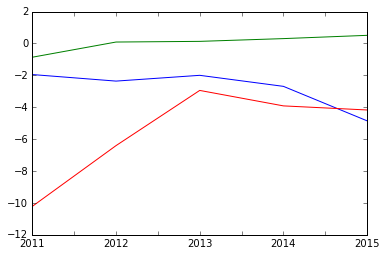

In [36]:
wit['GGXCNL_NGDP'].plot(legend=False)

## Pivoting 

This is a more direct approach to the same problem...  

In [43]:
wi

2011  \
Country   Variable    ISO Description                              Units                     
Argentina GGXCNL_NGDP ARG General government net lending/borrowing Percent of GDP   -1.949   
          GGXWDG_NGDP ARG General government gross debt            Percent of GDP   35.763   
Germany   GGXCNL_NGDP DEU General government net lending/borrowing Percent of GDP   -0.861   
          GGXWDG_NGDP DEU General government gross debt            Percent of GDP   77.928   
Greece    GGXCNL_NGDP GRC General government net lending/borrowing Percent of GDP  -10.215   
          GGXWDG_NGDP GRC General government gross debt            Percent of GDP  170.960   

                                                                                      2012  \
Country   Variable    ISO Description                              Units                     
Argentina GGXCNL_NGDP ARG General government net lending/borrowing Percent of GDP   -2.359   
          GGXWDG_NGDP ARG General government gross debt            Percent of GDP   37.328   
Germany   GGXCNL_NGDP DEU General government net lending/borrowing Percent of GDP    0.091   
          GGXWDG_NGDP DEU General government gross debt            Percent of GDP   79.311   
Greece    GGXCNL_NGDP GRC General government net lending/borrowing Percent of GDP   -6.406   
          GGXWDG_NGDP GRC General government gross debt            Percent of GDP  156.494   

                                                                                      2013  \
Country   Variable    ISO Description                              Units                     
Argentina GGXCNL_NGDP ARG General government net lending/borrowing Percent of GDP   -1.997   
          GGXWDG_NGDP ARG General government gross debt            Percent of GDP   40.217   
Germany   GGXCNL_NGDP DEU General government net lending/borrowing Percent of GDP    0.133   
          GGXWDG_NGDP DEU General government gross debt            Percent of GDP   76.978   
Greece    GGXCNL_NGDP GRC General government net lending/borrowing Percent of GDP   -2.944   
          GGXWDG_NGDP GRC General government gross debt            Percent of GDP  174.951   

                                                                                      2014  \
Country   Variable    ISO Description                              Units                     
Argentina GGXCNL_NGDP ARG General government net lending/borrowing Percent of GDP   -2.689   
          GGXWDG_NGDP ARG General government gross debt            Percent of GDP   45.282   
Germany   GGXCNL_NGDP DEU General government net lending/borrowing Percent of GDP    0.306   
          GGXWDG_NGDP DEU General government gross debt            Percent of GDP   74.621   
Greece    GGXCNL_NGDP GRC General government net lending/borrowing Percent of GDP   -3.914   
          GGXWDG_NGDP GRC General government gross debt            Percent of GDP  177.054   

                                                                                      2015  
Country   Variable    ISO Description                              Units                    
Argentina GGXCNL_NGDP ARG General government net lending/borrowing Percent of GDP   -4.852  
          GGXWDG_NGDP ARG General government gross debt            Percent of GDP   52.137  
Germany   GGXCNL_NGDP DEU General government net lending/borrowing Percent of GDP    0.511  
          GGXWDG_NGDP DEU General government gross debt            Percent of GDP   70.746  
Greece    GGXCNL_NGDP GRC General government net lending/borrowing Percent of GDP   -4.171  
          GGXWDG_NGDP GRC General government gross debt            Percent of GDP  196.950

In [45]:
wi.pivot(index=wi.columns, columns='ISO', values='GGXWDG_NGDP')

KeyError: 'GGXWDG_NGDP'

## Stacking and unstacking 

This is mostly what we do:  we choose observations that satisfy one or more conditions.  We choose 

**Exercise.** BDS data...  ??